## 경구약제 이미지 데이터 EDA
### 전체 요약 (Overall Summary)
- 데이터 개요 : 총 4,526개의 이미지와 73개의 클래스로 구성되어 있습니다.
- 데이터 품질 : 누락 파일 0개, 유효하지 않은 Bbox 단 2개로 전반적인 데이터 품질이 매우 양호합니다.
유효하지 않은 Bbox 2개는 전체 데이터(4,526개)에 비해 매우 적기 때문에, 이들을 억지로 수정해서 사용하기보다는 학습 과정에서 무시하고 건너뛰는 것이 가장 깔끔하고 효과적인 방법으로 판단하였습니다.
- 핵심 발견 : **심각한 클래스 불균형**이 존재합니다. 가장 많은 클래스(기넥신에프정, 514개)는 가장 적은 클래스(브린텔릭스정, 7개)보다 약 73배 더 많습니다.
- 기타 특징 : 이미지 품질은 대체로 양호하나 일부 약간 흐릿한 이미지가 포함되어 있으며, Bbox의 크기와 모양은 다양하게 분포합니다.
- 향후 전략 : 따라서, 데이터 증강(Augmentation)과 손실 함수(Loss Function)의 전략적인 선택이 모델 성능 향상의 핵심이 될 것입니다.

---

### 0단계: 초기 설정 (라이브러리, 폰트, 경로)

In [3]:
# === 0단계: 라이브러리 임포트, 폰트 및 경로 설정 ===
import json
import random
import platform
import math
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import cv2  # pip install opencv-python
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit # pip install scikit-learn
from sklearn.cluster import KMeans # 알약 색상 분석용

# --- 한글 폰트 설정 (그래프 깨짐 방지) ---
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# --- 데이터 경로 ---
IMG_ROOT = Path("D:/datasets/train_images")
ANN_PATH = Path("D:/datasets/train_annotations")

# ------------------------------------
print("라이브러리 및 설정 준비 완료!")
print(f"이미지 폴더 경로: {IMG_ROOT}")
print(f"Annotation 경로: {ANN_PATH}")

라이브러리 및 설정 준비 완료!
이미지 폴더 경로: D:\datasets\train_images
Annotation 경로: D:\datasets\train_annotations


### 1단계: 데이터 로드 및 통합

In [4]:
# === 1단계: 데이터 로드 및 통합 ===
def load_all_coco(ann_path: Path):
    """폴더 안의 모든 COCO JSON 파일을 읽어 하나의 dict으로 병합합니다."""
    if ann_path.is_file():
        return json.loads(ann_path.read_text(encoding="utf-8"))

    images, annotations, cat_names = [], [], set()
    img_id, ann_id = 1, 1
    json_files = sorted(list(ann_path.rglob("*.json")) + list(ann_path.rglob("*.son")))

    for jp in json_files:
        try:
            d = json.loads(jp.read_text(encoding="utf-8"))
        except Exception:
            print(f"경고: {jp} 파일을 읽는 데 실패했습니다.")
            continue

        old2new_img_id = {}
        for im in d.get("images", []):
            images.append({
                "id": img_id,
                "file_name": Path(im["file_name"]).name,
                "width": int(im["width"]),
                "height": int(im["height"])
            })
            old2new_img_id[im["id"]] = img_id
            img_id += 1

        cats = {c["id"]: c.get("name", str(c["id"])) for c in d.get("categories", [])}
        for name in cats.values():
            cat_names.add(name)

        for a in d.get("annotations", []):
            if a.get("image_id") not in old2new_img_id:
                continue
            annotations.append({
                "id": ann_id,
                "image_id": old2new_img_id[a["image_id"]],
                "category_name": cats.get(a["category_id"], str(a["category_id"])),
                "bbox": a["bbox"],
                "iscrowd": int(a.get("iscrowd", 0)),
            })
            ann_id += 1

    names = sorted(list(cat_names))
    name2gid = {name: i + 1 for i, name in enumerate(names)}
    categories = [{"id": name2gid[name], "name": name} for name in names]
    for a in annotations:
        a["category_id"] = name2gid[a["category_name"]]

    return {"images": images, "annotations": annotations, "categories": categories}

# 함수를 실행하여 모든 데이터를 COCO 변수에 저장
COCO = load_all_coco(ANN_PATH)
print(f"통합 완료 >> 이미지: {len(COCO['images'])}개, Annotation: {len(COCO['annotations'])}개, 클래스: {len(COCO['categories'])}개")

통합 완료 >> 이미지: 4526개, Annotation: 4526개, 클래스: 73개


### 2단계: 데이터 인덱싱

In [5]:
# === 2단계: 데이터 인덱싱 ===

# 이미지 ID -> 이미지 메타 정보(파일명, 크기 등)
img_meta = {im["id"]: im for im in COCO["images"]}
# 카테고리 ID -> 카테고리 이름
cat_id2name = {c["id"]: c["name"] for c in COCO["categories"]}
# 이미지 ID -> 해당 이미지의 모든 Annotation 리스트
ann_by_img = defaultdict(list)
for a in COCO["annotations"]:
    ann_by_img[a["image_id"]].append(a)
# 이미지 ID -> 실제 이미지 파일 경로
id2path = {im["id"]: (IMG_ROOT / Path(im["file_name"]).name) for im in COCO["images"]}

print("데이터 인덱싱 완료!")

데이터 인덱싱 완료!


### 3단계: 데이터 무결성 검사 (Sanity Check)

In [6]:
# === 3단계: 데이터 무결성 검사 (Sanity Check) ===

missing_files, invalid_bbox_count = [], 0

# 3-1. 이미지 파일이 실제로 존재하는지 확인
for img_id, p in id2path.items():
    if not p.exists():
        missing_files.append((img_id, str(p)))

# 3-2. Bbox 좌표가 유효한지 확인
for a in COCO["annotations"]:
    im = img_meta.get(a["image_id"])
    if not im: continue
    x, y, w, h = a["bbox"]
    W, H = im["width"], im["height"]
    if not ((w > 0) and (h > 0) and (x >= 0) and (y >= 0) and (x + w <= W) and (y + h <= H)):
        invalid_bbox_count += 1

print("--- 데이터 무결성 검사 결과 ---")
print(f"누락된 이미지 파일 수: {len(missing_files)}")
print(f"유효하지 않은 Bbox 수: {invalid_bbox_count}")

--- 데이터 무결성 검사 결과 ---
누락된 이미지 파일 수: 0
유효하지 않은 Bbox 수: 2


### 4단계: 핵심 통계 분석

--- 💊 클래스 분포 요약 (상위 10개) ---
  - 기넥신에프정(은행엽엑스)(수출용): 514개
  - 일양하이트린정 2mg: 240개
  - 보령부스파정 5mg: 180개
  - 뮤테란캡슐 100mg: 172개
  - 가바토파정 100mg: 143개
  - 동아가바펜틴정 800mg: 139개
  - 아토젯정 10/40mg: 113개
  - 리바로정 4mg: 111개
  - 리피토정 20mg: 109개
  - 크레스토정 20mg: 108개

--- 💊 클래스 분포 요약 (하위 5개) ---
  - 졸로푸트정 100mg: 11개
  - 쿠에타핀정 25mg: 10개
  - 자이프렉사정 2.5mg: 9개
  - 렉사프로정 15mg: 9개
  - 브린텔릭스정 20mg: 7개


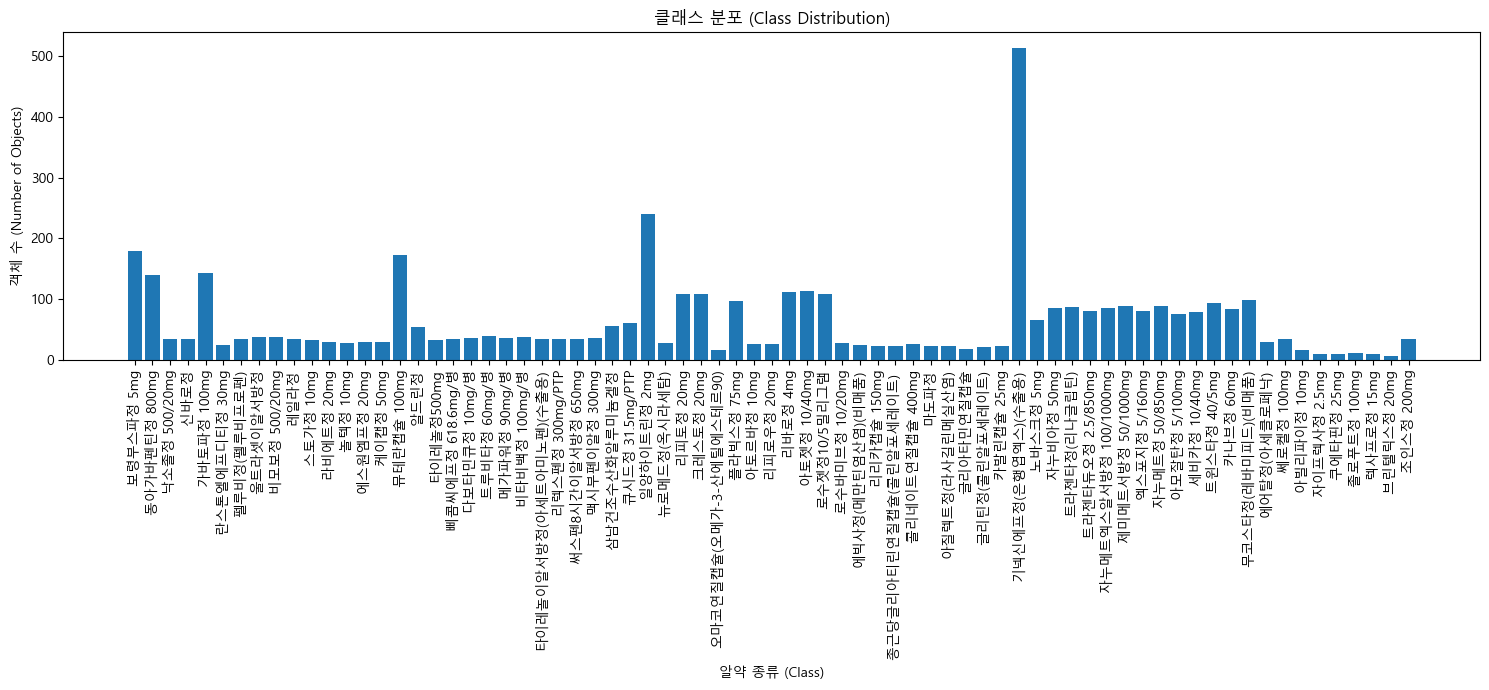

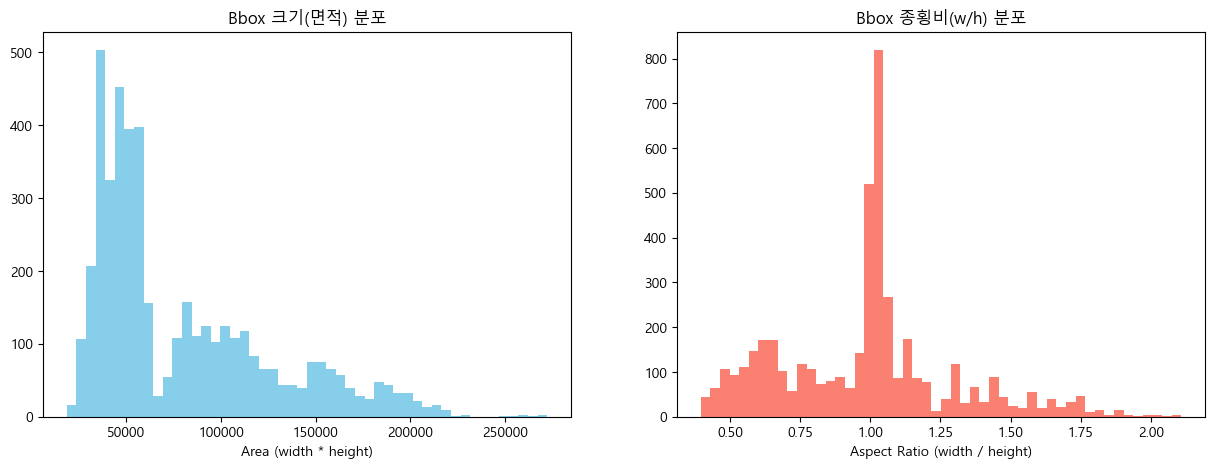

In [7]:
# === 4단계: 핵심 통계 분석 ===
# 설명: 데이터의 전반적인 특징을 통계와 그래프로 파악합니다.
#      전체 분포를 시각화함과 동시에, 가장 많거나 적은 클래스를
#      텍스트로 출력하여 구체적인 수치를 확인합니다.

# 4-1. 클래스 분포 분석 (어떤 알약이 많고 적은가?)
category_ids = [ann['category_id'] for ann in COCO['annotations']]
category_counts = Counter(category_ids)

# --- (추가) 정량적 텍스트 요약 ---
print("--- 💊 클래스 분포 요약 (상위 10개) ---")
# most_common(10)은 가장 흔한 (ID, 개수) 튜플 10개를 리스트로 반환합니다.
for cat_id, count in category_counts.most_common(10):
    # cat_id2name 딕셔너리를 이용해 ID를 실제 알약 이름으로 변환합니다.
    print(f"  - {cat_id2name[cat_id]}: {count}개")

print("\n--- 💊 클래스 분포 요약 (하위 5개) ---")
# most_common() 전체 리스트에서 뒤에서 5개를 가져옵니다.
for cat_id, count in category_counts.most_common()[-5:]:
    print(f"  - {cat_id2name[cat_id]}: {count}개")
# ------------------------------------

# --- (기존) 전체 분포 시각화 ---
class_names = [cat_id2name[cat_id] for cat_id in category_counts.keys()]

plt.figure(figsize=(15, 7))
plt.bar(class_names, category_counts.values())
plt.xlabel('알약 종류 (Class)')
plt.ylabel('객체 수 (Number of Objects)')
plt.title('클래스 분포 (Class Distribution)')
plt.xticks(rotation=90) # 클래스 이름이 많아 겹치므로 90도 회전
plt.tight_layout() # 레이아웃을 깔끔하게 조정
plt.show()


# 4-2. Bbox 크기 및 종횡비 분석 (알약의 크기와 모양은 어떠한가?)
areas = []
aspect_ratios = []
for ann in COCO['annotations']:
    w, h = ann['bbox'][2], ann['bbox'][3]
    if w > 0 and h > 0:
        areas.append(w * h)
        aspect_ratios.append(w / h)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(areas, bins=50, color='skyblue')
axes[0].set_title('Bbox 크기(면적) 분포')
axes[0].set_xlabel('Area (width * height)')

axes[1].hist(aspect_ratios, bins=50, color='salmon')
axes[1].set_title('Bbox 종횡비(w/h) 분포')
axes[1].set_xlabel('Aspect Ratio (width / height)')
plt.show()

### 5단계 : 모델 파라미터 추천을 위한 분석

In [8]:
# === 5단계 (심화): 모델 파라미터 추천을 위한 분석 ===

# 5-1. FPN 스케일 커버리지 분석
def fpn_coverage(coco, sizes=(32,64,128,256,512)):
    bins = Counter()
    for a in coco["annotations"]:
        w, h = a["bbox"][2], a["bbox"][3]
        s = math.sqrt(max(w*h, 1e-6))
        j = min(range(len(sizes)), key=lambda i: abs(s - sizes[i]))
        bins[sizes[j]] += 1
    tot = max(1, len(coco["annotations"]))
    return {k: round(v/tot, 3) for k, v in sorted(bins.items())}

# 5-2. 데이터 기반 하이퍼파라미터 추천
aspect_ratios.sort()
p90_ar = aspect_ratios[int(len(aspect_ratios) * 0.9)] if aspect_ratios else 2.0
cover = fpn_coverage(COCO)

if areas and np.median(areas) < 64*64:
    anchor_sizes = [16, 32, 64, 128, 256]
else:
    anchor_sizes = [32, 64, 128, 256, 512]

anchor_ratios = [0.5, 1.0, 2.0]
if p90_ar > 2.5:
    anchor_ratios.append(3.0)

print("--- (심화) 모델 파라미터 추천 ---")
print("FPN 스케일별 객체 분포:", cover)
print("-> 추천 Anchor Sizes (P3~P7):", anchor_sizes)
print("-> 추천 Anchor Ratios:", anchor_ratios)

--- (심화) 모델 파라미터 추천 ---
FPN 스케일별 객체 분포: {128: 0.155, 256: 0.72, 512: 0.125}
-> 추천 Anchor Sizes (P3~P7): [32, 64, 128, 256, 512]
-> 추천 Anchor Ratios: [0.5, 1.0, 2.0]


### 6단계 (알약 특화): 데이터 품질 및 특징 분석

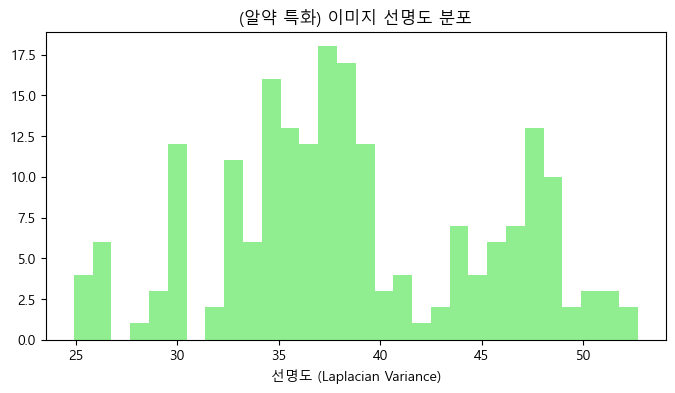

이미지 선명도(중앙값): 37.81 (값이 낮을수록 흐릿함)


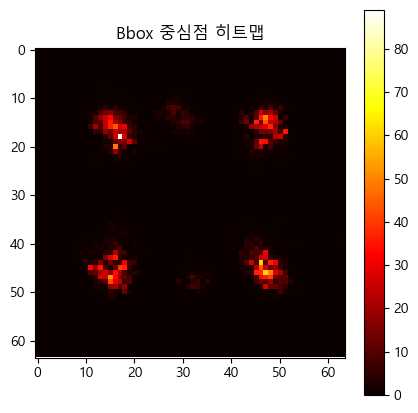


--- (알약 특화) 샘플 알약 주요 색상 분석 ---


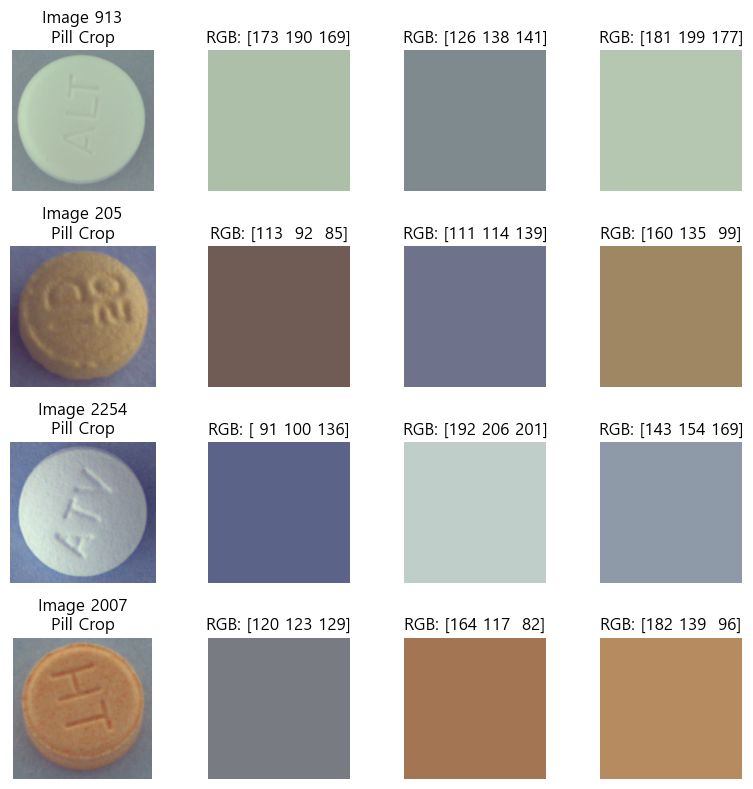

In [9]:
# === 6단계 (알약 특화): 데이터 품질 및 특징 분석 ===

# 6-1. 이미지 선명도(Blur) 분석
random.seed(42)
sample_ids = random.sample(list(id2path.keys()), min(200, len(id2path)))
blurs = []
for img_id in sample_ids:
    p = str(id2path[img_id])
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if img is None: continue
    blurs.append(cv2.Laplacian(img, cv2.CV_64F).var())

plt.figure(figsize=(8, 4))
plt.hist(blurs, bins=30, color='lightgreen')
plt.title("(알약 특화) 이미지 선명도 분포")
plt.xlabel("선명도 (Laplacian Variance)")
plt.show()
print(f"이미지 선명도(중앙값): {np.median(blurs):.2f} (값이 낮을수록 흐릿함)")

# 6-2. Bbox 중심점 히트맵
grid = 64; heat = np.zeros((grid, grid), dtype=float)
for a in COCO["annotations"]:
    im = img_meta[a["image_id"]]
    x,y,w,h = a["bbox"]; W,H = im["width"], im["height"]
    cx, cy = (x + w/2) / W, (y + h/2) / H
    ix, iy = min(grid-1, int(cx*grid)), min(grid-1, int(cy*grid))
    heat[iy, ix] += 1
plt.figure(figsize=(5, 5)); plt.imshow(heat, cmap='hot'); plt.title("Bbox 중심점 히트맵"); plt.colorbar(); plt.show()

# 6-3. 알약 색상 분석
def get_dominant_colors(image, k=3):
    pixels = np.array(image).reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(pixels)
    return kmeans.cluster_centers_.astype('uint8')

print("\n--- (알약 특화) 샘플 알약 주요 색상 분석 ---")
fig, axes = plt.subplots(len(sample_ids[:4]), 4, figsize=(8, len(sample_ids[:4])*2))
for i, img_id in enumerate(sample_ids[:4]):
    p = id2path[img_id]; anns = ann_by_img[img_id]
    if not (p.exists() and anns): continue
    ann = anns[0]; x, y, w, h = [int(v) for v in ann['bbox']]
    with Image.open(p) as im:
        pill_crop = im.crop((x, y, x+w, y+h)); colors = get_dominant_colors(pill_crop, k=3)
        axes[i, 0].imshow(pill_crop); axes[i, 0].set_title(f"Image {img_id}\nPill Crop"); axes[i, 0].axis('off')
        for j, color in enumerate(colors):
            axes[i, j+1].imshow([[color]]); axes[i, j+1].set_title(f"RGB: {color}"); axes[i, j+1].axis('off')
plt.tight_layout(); plt.show()

### 7단계: 시각적 검증

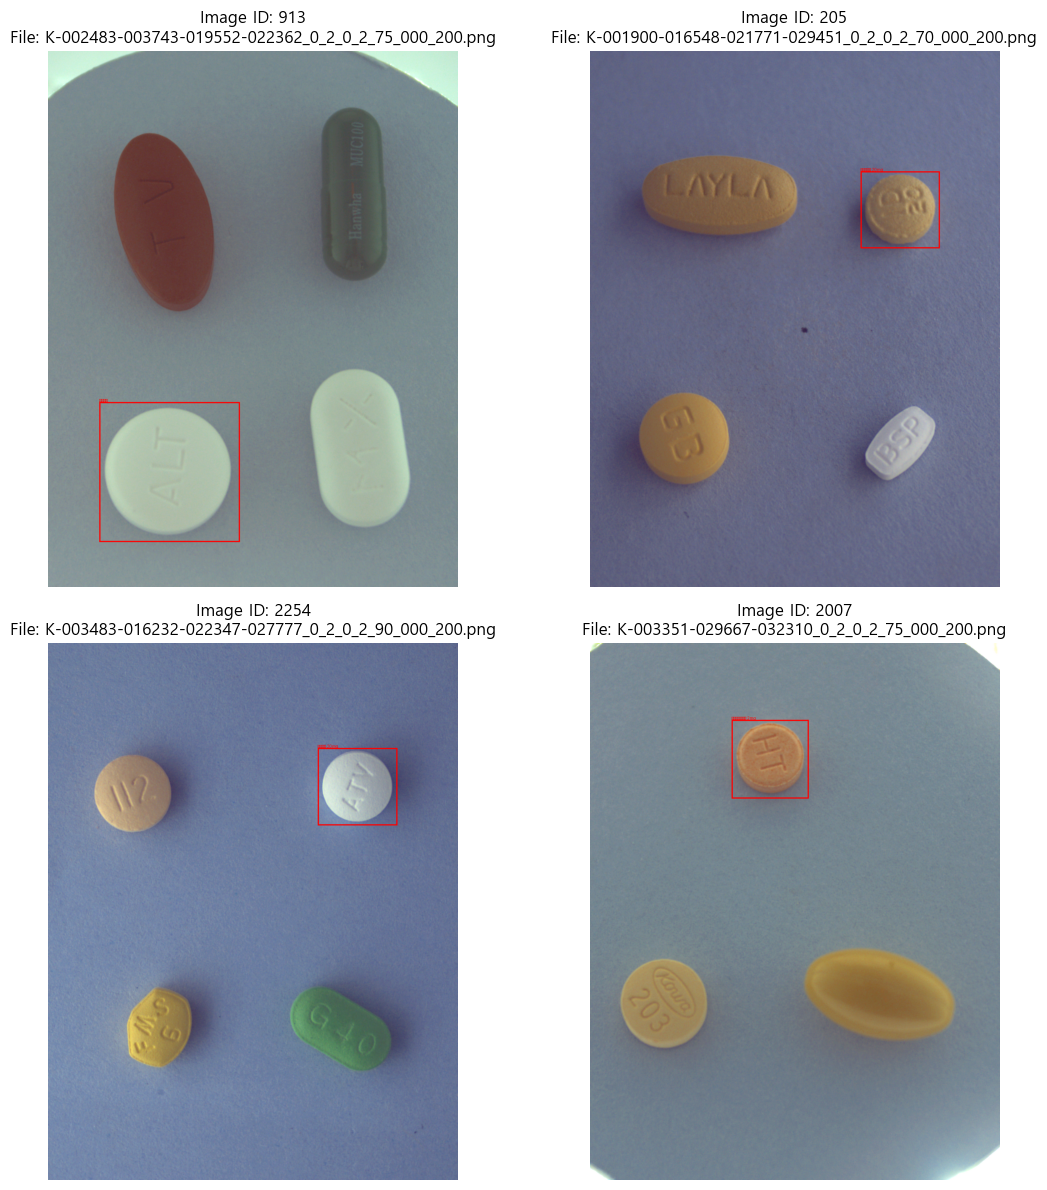

In [10]:
# === 7단계: 시각적 검증 ===

def draw_boxes(img_path: Path, anns):
    im = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(im, "RGBA")
    for a in anns:
        x, y, w, h = a["bbox"]
        cat_name = cat_id2name[a['category_id']]
        draw.rectangle([x, y, x + w, y + h], outline="red", width=3)
        draw.text((x, y - 10), cat_name, fill="red")
    return im

random.seed(42)
sample_image_ids = random.sample(list(ann_by_img.keys()), min(4, len(ann_by_img)))

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()
for i, img_id in enumerate(sample_image_ids):
    p = id2path[img_id]
    if p.exists():
        img_with_boxes = draw_boxes(p, ann_by_img[img_id])
        axes[i].imshow(img_with_boxes)
        axes[i].set_title(f"Image ID: {img_id}\nFile: {p.name}")
        axes[i].axis('off')
plt.tight_layout()
plt.show()

### 8단계: 학습 데이터 분할

In [11]:
# === 8단계: 학습 데이터 분할 ===

def get_group_key(file_name: str):
    stem = Path(file_name).stem
    for suf in ("_70", "_75", "_90"):
        if stem.endswith(suf):
            return stem[:-len(suf)]
    return stem

image_ids = np.array([im["id"] for im in COCO["images"]])
groups = np.array([get_group_key(im["file_name"]) for im in COCO["images"]])

gss = GroupShuffleSplit(n_splits=1, train_size=0.9, random_state=42)
train_idx, val_idx = next(gss.split(image_ids, groups=groups))
train_ids, val_ids = image_ids[train_idx].tolist(), image_ids[val_idx].tolist()

print("--- 데이터 분할 결과 ---")
print(f"총 이미지 수: {len(image_ids)}")
print(f"학습용 이미지 수 (Train): {len(train_ids)}")
print(f"검증용 이미지 수 (Validation): {len(val_ids)}")

--- 데이터 분할 결과 ---
총 이미지 수: 4526
학습용 이미지 수 (Train): 4060
검증용 이미지 수 (Validation): 466


### 9단계: 분석 결과 저장

In [13]:
# === 9단계: 분석 결과 저장 ===
# 설명: EDA 결과와 데이터 분할 정보를 JSON 파일로 저장합니다.
#      파일명에 'RetinaNet'을 명시하여, 이 분석 결과가 RetinaNet 모델을 위한
#      것임을 명확히 합니다.

output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True, parents=True)

# 9-1. EDA 요약 정보 저장
eda_summary = {
    "num_images": len(COCO["images"]),
    "num_annotations": len(COCO["annotations"]),
    "num_classes": len(COCO["categories"]),
    "class_names": [c["name"] for c in sorted(COCO["categories"], key=lambda x: x["id"])],
    # 모델링에 직접 사용할 추천 파라미터 포함
    "retinanet_recommend": {
        "anchor_sizes": [int(s) for s in anchor_sizes],
        "anchor_ratios": [float(r) for r in anchor_ratios]
    }
}
# (수정) 파일명 변경: eda_summary.json -> RetinaNet_eda_summary.json
summary_path = output_dir / "RetinaNet_eda_summary.json"
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(eda_summary, f, ensure_ascii=False, indent=2)
print(f"\nEDA 요약 파일 저장 완료: {summary_path.resolve()}")

# 9-2. 데이터 분할 결과 저장
splits = {"train_ids": train_ids, "val_ids": val_ids}
# (수정) 파일명 변경: splits.json -> RetinaNet_splits.json
split_path = output_dir / "RetinaNet_splits.json"
with open(split_path, "w", encoding="utf-8") as f:
    json.dump(splits, f, indent=2)
print(f"데이터 분할 파일 저장 완료: {split_path.resolve()}")


EDA 요약 파일 저장 완료: D:\AI_4_5\notebooks\outputs\RetinaNet_eda_summary.json
데이터 분할 파일 저장 완료: D:\AI_4_5\notebooks\outputs\RetinaNet_splits.json
